=== CONVERSION RESULTS ===

Total games: 140,082
Games with EUR prices: 140,082
Conversion success rate: 100.0%

=== SAMPLE ===
                        name  price currency  price_eur  type
0             Counter-Strike   8.19      EUR       8.19  game
1      Team Fortress Classic   4.99      EUR       4.99  game
2              Day of Defeat   4.99      EUR       4.99  game
3         Deathmatch Classic   4.99      EUR       4.99  game
4  Half-Life: Opposing Force   4.99      EUR       4.99  game

=== PRICE STATISTICS (in EUR) ===
count    140082.000000
mean          4.537070
std          10.678435
min           0.000000
25%           0.000000
50%           0.990000
75%           5.690000
max         999.000000
Name: price_eur, dtype: float64

=== TOP 10 MOST EXPENSIVE GAMES ===
                                              name  price_eur currency  \
41079            Ascent Free-Roaming VR Experience     999.00      EUR   
103609                           The Leverage Game     900.00   

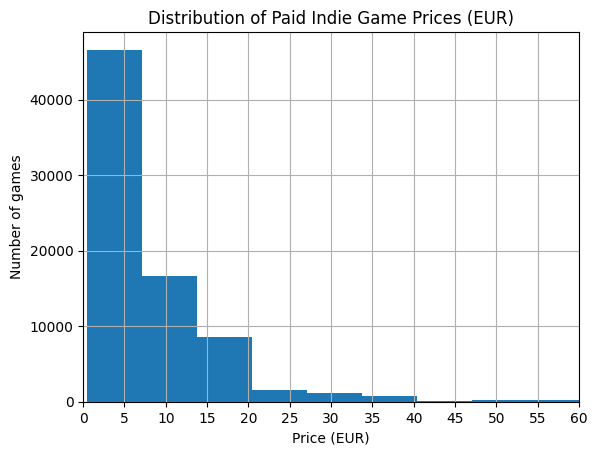

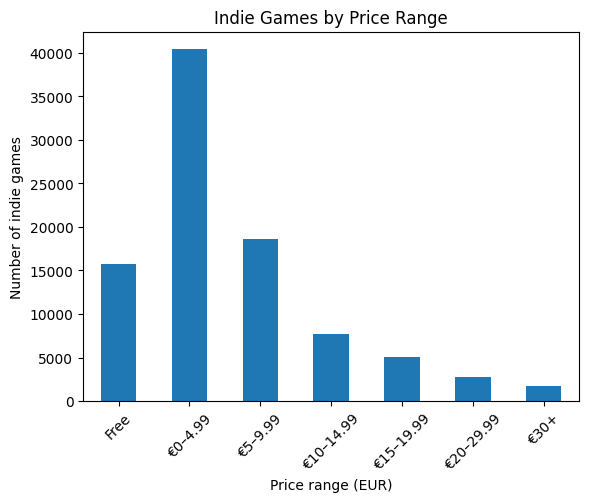

In [ ]:

#This cell is needed for Q2
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt


# --------------------------------------------------
# Load and parse (your existing code)
# --------------------------------------------------
df = pd.read_csv(
    "games.csv",
    sep=',',
    quotechar='"',
    escapechar='\\',
    on_bad_lines="skip",
    engine='python'
)

df.columns = df.columns.str.strip().str.replace('"', '', regex=False)

def extract_price_and_currency(x):
    if pd.isna(x) or x == '\\N' or x == 'N':
        return None, None
    
    try:
        x = str(x)
        
        # Extract price
        price_match = re.search(r'["\']?final["\']?\s*:\s*(\d+)', x)
        price = int(price_match.group(1)) / 100 if price_match else None
        
        # Extract currency
        currency_match = re.search(r'["\']?currency["\']?\s*:\s*["\']([A-Z]{3})["\']', x)
        currency = currency_match.group(1) if currency_match else None
        
        return price, currency
        
    except Exception:
        return None, None

df[["price", "currency"]] = df["price_overview"].apply(
    lambda x: pd.Series(extract_price_and_currency(x))
)


# --------------------------------------------------
# Exchange rates to EUR (as of Dec 31, 2024)
# --------------------------------------------------
exchange_rates_to_eur = {
    'EUR': 1.0,
    'USD': 1 / 1.0389,
    'GBP': 1 / 0.82918,
    'JPY': 1 / 163.06,
    'CAD': 1 / 1.4785,
    'AUD': 1 / 1.6631,
    'CHF': 1 / 0.9367,
    'CNY': 1 / 7.5496,
    'SEK': 1 / 11.4840,
    'NZD': 1 / 1.8417,
    'MXN': 1 / 21.2110,
    'SGD': 1 / 1.4159,
    'HKD': 1 / 8.0726,
    'NOK': 1 / 11.8500,
    'KRW': 1 / 1518.82,
    'TRY': 1 / 36.7285,
    'RUB': 1 / 103.50,
    'INR': 1 / 89.05,
    'BRL': 1 / 6.32,
    'ZAR': 1 / 19.2520,
    'DKK': 1 / 7.4578,
    'PLN': 1 / 4.2625,
    'THB': 1 / 35.54,
    'MYR': 1 / 4.67,
    'HUF': 1 / 410.25,
    'CZK': 1 / 25.185,
    'ILS': 1 / 3.82,
    'CLP': 1 / 1023.50,
    'PHP': 1 / 60.85,
    'AED': 1 / 3.814,
    'COP': 1 / 4562.00,
    'SAR': 1 / 3.896,
    'VND': 1 / 26380,
}

# --------------------------------------------------
# Convert all prices to EUR and round to 2 decimals
# --------------------------------------------------
def convert_to_eur(row):
    # 1. If the price is already 0 (free games), return 0 immediately
    # We don't need a currency to know that 0 * anything = 0
    if row['price'] == 0:
        return 0.0
    
    # 2. If price or currency is missing, return 0 as requested
    if pd.isna(row['price']) or pd.isna(row['currency']):
        return 0.0
    
    # 3. Look up the exchange rate
    rate = exchange_rates_to_eur.get(row['currency'])
    
    # 4. If currency is not in our dictionary, return 0
    if rate is None:
        return 0.0
    
    return round(row['price'] * rate, 2)
    
    return round(row['price'] * rate, 2)
df.loc[df['is_free'] == 1, 'price'] = 0
df['price_eur'] = df.apply(convert_to_eur, axis=1)
df['price_eur'] = df['price_eur'].fillna(0)
df['price'] = df['price'].fillna(0)



# --------------------------------------------------
# Results
# --------------------------------------------------
print("=== CONVERSION RESULTS ===\n")
print(f"Total games: {len(df):,}")
print(f"Games with non-zero EUR prices: {(df['price_eur'] > 0).sum():,}")
print(f"Conversion success rate: {df['price_eur'].notna().sum() / len(df) * 100:.1f}%")

print("\n=== SAMPLE ===")
print(df[['name', 'price', 'currency', 'price_eur','type']].head())

print("\n=== PRICE STATISTICS (in EUR) ===")
print(df['price_eur'].describe())

print("\n=== TOP 10 MOST EXPENSIVE GAMES ===")
most_expensive = df.nlargest(10, 'price_eur')[['name', 'price_eur', 'currency', 'release_date']]
print(most_expensive)
print(f"Loaded rows: {len(df)}")
df_games = df[df["type"] == "game"].copy()
df_games = df_games.drop(columns=['price_overview', 'release_date','type','languages'])
print(df_games.columns)
print(df_games.head(35))

 # --------------------------------------------------
# Q2 ANALYSIS — PRICE DISTRIBUTION
# --------------------------------------------------

# 1️⃣ Explicitly mark free games
df_games.loc[df_games["is_free"] == True, "price_bucket"] = "Free"

# 2️⃣ Bucket paid games ONLY
paid_mask = (df_games["is_free"] == False) & (df_games["price_eur"]>0)

bins = [0, 5, 10, 15, 20, 30, np.inf]
labels = [
    "€0–4.99",
    "€5–9.99",
    "€10–14.99",
    "€15–19.99",
    "€20–29.99",
    "€30+"
]

df_games.loc[paid_mask, "price_bucket"] = pd.cut(
    df_games.loc[paid_mask, "price_eur"],
    bins=bins,
    labels=labels,
    right=False
)

# --------------------------------------------------
# Plot 1 — Histogram (PAID games only)
# --------------------------------------------------

plt.figure()
df_games.loc[paid_mask, "price_eur"].hist(bins=150)
plt.xlim(0, 60)
plt.xticks(range(0, 61, 5))
plt.xlabel("Price (EUR)")
plt.ylabel("Number of games")
plt.title("Distribution of Paid Indie Game Prices (EUR)")
plt.show()

# --------------------------------------------------
# Plot 2 — Price buckets (Free INCLUDED)
# --------------------------------------------------

bucket_order = [
    "Free",
    "€0–4.99",
    "€5–9.99",
    "€10–14.99",
    "€15–19.99",
    "€20–29.99",
    "€30+"
]

bucket_counts = (
    df_games["price_bucket"]
    .value_counts()
    .reindex(bucket_order)
)

plt.figure()
bucket_counts.plot(kind="bar")
plt.xlabel("Price range (EUR)")
plt.ylabel("Number of indie games")
plt.title("Indie Games by Price Range")
plt.xticks(rotation=45)
plt.show()


In [45]:
#This cell is for answering Q1
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt


# --------------------------------------------------
# Load and parse (your existing code)
# --------------------------------------------------
df = pd.read_csv(
    "games.csv",
    sep=',',
    quotechar='"',
    escapechar='\\',
    on_bad_lines="skip",
    engine='python'
)
reviews_df = pd.read_csv(
    "reviews.csv",
    sep=",",
    engine="python",
    quoting=3,              # csv.QUOTE_NONE
    escapechar="\\",
    on_bad_lines="skip",
    encoding="utf-8",
)

df.columns = df.columns.str.strip().str.replace('"', '', regex=False)
genres_df = pd.read_csv(
    "genres.csv",
    sep=",",
    quotechar='"',
    engine="python"
)

print(genres_df.columns.tolist())

tags_df = pd.read_csv(
    "tags.csv",
    engine="python",
    sep = ",",
    quotechar='"'

    
)


#To improve safety
genres_df["genre"] = genres_df["genre"].str.strip()
tags_df["tag"] = tags_df["tag"].str.strip()

df_games = df[df["type"] == "game"][["app_id", "name"]].copy()
print("========================================")
print(df_games.head())
#Merge table using inner join
genres_indie = genres_df.merge(df_games, on="app_id", how="inner")
tags_indie = tags_df.merge(df_games, on="app_id", how="inner")

#Excluded Genres
EXCLUDED_GENRES = {
    "Indie",
    "Early Access",
    "Free To Play",
    "Free to Play",
    "Utilities",
    "Software",
    "Animation & Modeling",
    "Design & Illustration",
    "Education",
    "Audio Production",
    "Video Production",
    "Web Publishing",
    "Accounting",
    "Photo Editing",
    "Game Development",
    "Tutorial"
}
CANONICAL_GENRES = {
    "Action": ["Actie", "Ackja", "Azione","Action"],
    "Adventure": ["Aventura", "Abenteuer","Aventure","Avontuur","Eventyr","Avventura","Seikkailu","Adventure"],
    "RPG": ["Rollenspiel", "Rol", "GDR","Roolipelit","RPG"],
    "Strategy": ["Strategie", "Estrategia", "Strategia","Strategi","Strategy"],
    "Simulation": ["Simuladores", "Simulationen", "Simulatie","Simulaatio","Simulering","Simulation"],
    "Casual": ["Gelegenheitsspiele", "Occasionnel", "Passatempo","Casual"],
    "Racing": ["Carreras","Course automobile","Race","Racing"],
    "Sports": ["Deportes", "Sport"],
    "Massively Multiplayer": ["Multijugador masivo","Massivement multijoueur","MMO","Massively Multiplayer"],
}
def normalize_genre(raw_genre):
    g = raw_genre.strip()
    for canonical, variants in CANONICAL_GENRES.items():
        for v in variants:
            if v in g:
                return canonical
    return None

genres_filtered = genres_indie[
    ~genres_indie["genre"].isin(EXCLUDED_GENRES)
].copy()
genres_filtered["genre_normalized"] = genres_filtered["genre"].apply(normalize_genre)

genres_clean = genres_filtered.dropna(subset=["genre_normalized"])

genre_counts = (
    genres_clean["genre_normalized"]
    .value_counts()
    .reset_index()
)
genre_counts.columns = ["genre", "game_count"]
genre_counts["genre"] = genre_counts["genre"].astype(str)
genre_counts.columns = ["genre", "game_count"]
unique_values = genre_counts.genre.unique()
print("========== this part is for weighted engagement part===========================")
print("Columns in reviews.csv:")
print(reviews_df.columns.tolist())
print(f"The number of rows loaded is: {len(reviews_df)}")
print("\nSample rows:")
print(reviews_df.head())
# Clean column names
reviews_df.columns = reviews_df.columns.str.replace('"', '', regex=False)

# Convert numeric columns
numeric_cols = [
    "positive", "negative", "total",
    "recommendations", "metacritic_score"
]
for col in reviews_df.columns:
    reviews_df[col] = (
        reviews_df[col]
        .astype(str)
        .str.replace('"', '', regex=False)
        .replace('N', np.nan)
    )

for col in numeric_cols:
    reviews_df[col] = pd.to_numeric(reviews_df[col], errors="coerce")

# Remove quotes from all string cells
reviews_df = reviews_df.applymap(
    lambda x: x.replace('"', '') if isinstance(x, str) else x
)

reviews_df["app_id"] = pd.to_numeric(
    reviews_df["app_id"],
    errors="coerce"
)
reviews_df = reviews_df.dropna(subset=["app_id"])
reviews_df["app_id"] = reviews_df["app_id"].astype(int)
print(reviews_df.head(10))
print(reviews_df.dtypes)
print(reviews_df.head())

genres_with_reviews = genres_clean.merge(
    reviews_df[["app_id", "total"]],
    on="app_id",
    how="left"
)

genres_with_reviews["total"] = genres_with_reviews["total"].fillna(0)

genre_popularity = (
    genres_with_reviews
    .groupby("genre_normalized")
    .agg(
        games_count=("app_id", "nunique"),
        total_reviews=("total", "sum"),
        avg_reviews_per_game=("total", "mean")
    )
    .sort_values("total_reviews", ascending=False)
    .reset_index()
)

print(genre_popularity)












#print(f"++++==+++++++++ the unique values are {unique_values} ")

# print("Total genre rows:", len(genres_df))
# print("Indie games rows:", len(df_games))
# print("Genres after merge:", len(genres_indie))
# print(f"Total tags rows, {len(tags_df)} ")


# --------------------------------------------------
# Final genre counts (9 canonical genres)
# --------------------------------------------------

genre_counts = genre_counts.sort_values("game_count", ascending=True)


# --------------------------------------------------
# Plot — Horizontal bar chart (ALL genres)
# --------------------------------------------------

# plt.figure(figsize=(10, 6))

# plt.barh(
#     genre_counts["genre"],
#     genre_counts["game_count"],
#     color="steelblue"
# )

# plt.xlabel("Number of indie games")
# plt.ylabel("Genre")
# plt.title("Popularity of Indie Game Genres")

# plt.tight_layout()
# plt.show()
# print("============================== For tags")
# tag_counts = (
#     tags_indie["tag"]
#     .value_counts()
#     .reset_index()
# )

# tag_counts.columns = ["tag", "game_count"]
# top_tags = tag_counts.head(20)

# plt.figure()
# top_tags.plot(
#     kind="bar",
#     x="tag",
#     y="game_count",
#     legend=False
# )

# plt.xlabel("Tag")
# plt.ylabel("Number of indie games")
# plt.title("Top 20 Most Popular Indie Game Tags")
# plt.xticks(rotation=45, ha="right")
# plt.show()
# print(df["name"])

['app_id', 'genre']
   app_id                       name
0      10             Counter-Strike
1      20      Team Fortress Classic
2      30              Day of Defeat
3      40         Deathmatch Classic
4      50  Half-Life: Opposing Force
========== this part is for weighted engagement part===========================
Columns in reviews.csv:
['"app_id"', '"review_score"', '"review_score_description"', '"positive"', '"negative"', '"total"', '"metacritic_score"', '"reviews"', '"recommendations"', '"steamspy_user_score"', '"steamspy_score_rank"', '"steamspy_positive"', '"steamspy_negative"']
The number of rows loaded is: 137158

Sample rows:
  "app_id" "review_score" "review_score_description" "positive" "negative"  \
0     "10"            "9"  "Overwhelmingly Positive"   "235403"     "6207"   
1     "20"            "8"            "Very Positive"     "7315"     "1094"   
2     "30"            "8"            "Very Positive"     "6249"      "672"   
3     "40"            "8"            "V

/var/folders/5g/lwhn35h16cz_x3xfvc5gwgb80000gn/T/ipykernel_56214/3350984389.py:140: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  reviews_df = reviews_df.applymap(


   app_id review_score review_score_description  positive  negative     total  \
0      10            9  Overwhelmingly Positive  235403.0    6207.0  241610.0   
1      20            8            Very Positive    7315.0    1094.0    8409.0   
2      30            8            Very Positive    6249.0     672.0    6921.0   
3      40            8            Very Positive    2542.0     524.0    3066.0   
4      50            9  Overwhelmingly Positive   22263.0    1111.0   23374.0   
5      60            8            Very Positive    4791.0    1013.0    5804.0   
6      70            9  Overwhelmingly Positive  129364.0    4652.0  134016.0   
7      80            8            Very Positive   23316.0    2220.0   25536.0   
8     130            8            Very Positive   15859.0    1330.0   17189.0   
9     219            8            Very Positive     132.0      10.0     142.0   

   metacritic_score reviews  recommendations steamspy_user_score  \
0              88.0     NaN         1532